In [78]:
import pandas as pd
from VisaulizeArchitecture import *
import random
from math import fsum, e, log

In [79]:
def Sigmoid(x):
    return 1/(1+e**(-x))

def ActiveFunc(x):
    return Sigmoid(x)

def h0(x):
    return Sigmoid(x)

def TransposeMatrix(X):
    if (len(X)==1 and len(X[0])>1):
        return [[value] for value in X[0]]
    elif (len(X)>1 and len(X[0])==1):
        return [value[0] for value in X]
    return [[X[j][i] for j in range(len(X))] for i in range(len(X[0]))]

def MultiplyMatrices(A, B):
    return [[sum(a * b for a, b in zip(A_row, B_col))
                        for B_col in zip(*B)]
                                for A_row in A]

In [80]:
pand = pd.read_csv('../Data/LogicalOperator_AND.csv', sep=',')
pand

,A,B,Q
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,1
4,0,0,0
5,0,1,0
6,1,0,0
7,1,1,1


In [81]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.z, self.a = [], []
        self.d, self.architecture = [], {}
        self.LearningRate = 0.001
        self.thetaList = []
        self.dC = []

In [82]:
def get_architecture(x, y, HiddenLayer=1):
    input_units = len(x)
    output_inits = len(y)
    hiden_layers = list()
    for i in range(HiddenLayer):
        hiden_layers.append(input_units)
    return {
        'input_units': input_units,
        'hiden_layers': hiden_layers,
        'output_units': output_inits
    }

Init weights randomly

In [83]:
def initalize_weights(architecture):
    input_unit = architecture['input_units']
    output_unit = architecture['output_units']
    hiden_layer = architecture['hiden_layers']
    totalLayers = len(hiden_layer)+2
    thetaList = [list() for _ in range(totalLayers-1)]
    for i in range(totalLayers-1):
        if (i==0):
            n, m = hiden_layer[0], input_unit
        elif (i==totalLayers-2):
            n, m = output_unit, hiden_layer[len(hiden_layer)-1]
        else:
            n, m = hiden_layer[i], hiden_layer[i-1]
        thetaList[i] = [[random.uniform(0,1) for _ in range(m+1)] for _ in range(n)]
    return thetaList

<h2>Forward Propagation</h2>

$${z}^{(i)} = {\theta}^{(i-1)} {a}^{(i-1)}$$
$${a}^{(i)} = g({z}^{(i)})$$
$$with: {a[0]}^{(i)}=bias$$
$${z}^{(0)} = \varnothing$$
$${a}^{(0)} = x$$

In [84]:
def ForwardPropagation(data):
    hiden_layer = data.architecture['hiden_layers']
    totalLayers = len(data.architecture['hiden_layers'])+2
    a, z = list(), list()
    for i in range(totalLayers):
        if (i==0):
            a.append(data.x)
            z.append([])
        else:
            tempA, theta = a[i-1], data.thetaList[i-1]
            newZ = [[theta[unit][0]+fsum([tempA[k][j]*theta[unit][k+1] 
                for k in range(len(tempA))]) 
                    for j in range(len(tempA[0]))]
                        for unit in range(len(theta))]
            z.append(newZ)
            newA = [[ActiveFunc(value) for value in row] for row in newZ]
            a.append(newA)
    return a, z

<h2>Cost Function

$$J(\theta) = -\frac{1}{m} [\sum \limits_{i=1}^{m} \sum \limits_{k=1}^{K} {y[k]}^{(i)}log(h\theta({x}^{(i)}))[k] + (1-{y[k]}^{(i)})log(1-(h\theta({x}^{(i)})))[k]]$$

In [85]:
def ComputeCost(x, y):
    m = len(x[0])
    cost = -1/m
    sigma = fsum([fsum([y[k][i]*log(h0(x[k][i])) + (1-y[k][i])*log(1-h0(x[k][i])) 
        for i in range(m)])
            for k in range(len(y))])
    return cost * sigma

<h2>Backprogation</h2>

$${\delta}^{(i)} = {{\theta}^{(i)}}^{T} {\delta}^{(i+1)} * g'({z}^{(i)})$$
$${\Delta[i][j]}^{(l)} += {a[j]}^{(l)} {\delta[i]}^{(l+1)}$$
$$where: {D[i][j]}^{(l)}=\frac{1}{m} {\Delta[i][j]}^{(l)} = \frac{\sigma}{\sigma {\theta[i][j]}^{(l)}}J(\theta)$$
$$with: {\delta}^{(0)} = \varnothing$$

In [86]:
def BackPropagation(data):
    input_unit = data.architecture['input_units']
    output_unit = data.architecture['output_units']
    hiden_layer = data.architecture['hiden_layers']
    totalLayers = len(hiden_layer)+2

    delta = [[] for _ in range(totalLayers)]
    delta[totalLayers-1] = [[valueH-valueY for valueY, valueH in zip(data.y[i], data.a[len(data.a)-1][i])]
                                for i in range(len(data.y))]

    for i in range(totalLayers-2, 0, -1):
        first = MultiplyMatrices(TransposeMatrix(data.thetaList[i]), delta[i+1])
        second = [[h0(value) for value in row] for row in data.z[i]]
        newD = MultiplyMatrices(first, TransposeMatrix(second))
        delta[i] = newD
    
    deltaCost = [[] for _ in range(totalLayers-1)]

    for l in range(len(deltaCost)):
        a = TransposeMatrix(data.a[l])
        d = delta[l+1]
        m = len(data.x[0])
        theta = data.thetaList[l]
        newC = [[0 for _ in row] for row in theta]

        for i in range(len(theta)):
            for j in range(len(theta[0])):
                newC[i][j] += (1/m)*fsum([a[j][k]*d[i][k] for k in range(len(a[j]))])
        deltaCost[l] = newC
        
    return deltaCost

<h2>Gradient Descent</h2>

$$
{\theta[i][j]}^{(l)} = {\theta[i][j]}^{(l)} - \alpha\frac{\sigma}{\sigma {\theta[i][j]}^{(l)}}J(\theta)
$$

In [87]:
def GradientDescent(data, learningRate):
    return [[[valueT-learningRate*valueG 
        for valueT, valueG in zip(unitT, unitG)] 
            for unitT, unitG in zip(layerT, layerG)] 
                for layerT, layerG in zip(data.thetaList, data.dC)]

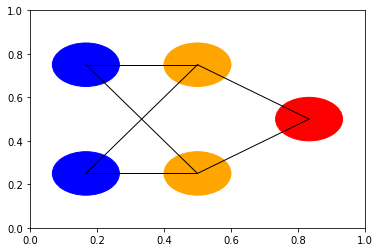

Cost after iteration 0: 0.933683
Cost after iteration 100: 0.909904
Cost after iteration 200: 0.887620
Cost after iteration 300: 0.867195
Cost after iteration 400: 0.848804
Cost after iteration 500: 0.832484
Cost after iteration 600: 0.818162
Cost after iteration 700: 0.805697
Cost after iteration 800: 0.794905
Cost after iteration 900: 0.785589


In [89]:
x = [list(pand['A']), list(pand['B'])]
y = [list(pand['Q'])]

def NeuralNetworkFormal(x, y, poches=1000, learningRate=0.01):
    data = NeuralNetwork(x, y)
    data.architecture = get_architecture(data.x, data.y)
    get_visual_architecture(data.architecture)
    data.thetaList = initalize_weights(data.architecture)

    for i in range(poches):
        data.a, data.z = ForwardPropagation(data)
        cost = ComputeCost(data.a[len(data.a)-1], data.y)
        data.dC = BackPropagation(data)
        data.thetaList = GradientDescent(data, learningRate)
        if (i%100==0):
            print ("Cost after iteration %i: %f" %(i, cost))

NeuralNetworkFormal(x, y)